---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

### Saverio Monaco
##### MAT: 2012264

# Homework 2 - Unsupervised Deep Learning
---
---

In [1]:
# if True all the models will be loaded from ./models folder
# if False all the models will be trained
load = False

### Dataset

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
import pandas as pd

# Deep Learning stuff
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
from sklearn.model_selection import KFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Images display and plots
import matplotlib.pyplot as plt
import plotly.express as px

# Other
import os
from tqdm.notebook import tqdm # Pretty progress bars
import random

# Automatic tuning tool
import optuna


In [4]:
# Setting the values of the seeds for reproducibility
#torch.manual_seed(2012264)    
np.random.seed(2012264)


In [5]:
if(os.path.isdir('./classifier_data/FashionMNIST')):
    download_data = False
else:
    download_data = True

# Transformation for data augmentation
augmentation = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.RandomVerticalFlip(p=0.5),
                     transforms.RandomCrop(28,padding=2)])

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=download_data,
                                                  transform = transforms.Compose([transforms.ToTensor()]) )
                                                      
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=download_data,
                                                  transform = transforms.Compose([transforms.ToTensor()]) ) 
    

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size = 1200, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle=True, num_workers=0)


In [7]:
# Check for the ranges of value of the images
# There are two standards of representing grayscale images:
#  1. Each pixel ranges from 0 to 1
#  2. Each pixel ranges from 0 to 255

# The second one present more numerical instability

absmax = -1000
absmin = +1000

# Checking the whole dataset, just to be sure
for image_batch, _ in train_dataloader:
    batch_max = torch.max(image_batch)
    batch_min = torch.min(image_batch)
    
    if batch_max > absmax:
        absmax = batch_max
    if batch_min < absmin:
        absmin = batch_min
        
print('TRAINING DATASET')
print(' range:', absmin.item(), '-', absmax.item())

absmax = -1000
absmin = +1000

# Checking the whole dataset, just to be sure
for image_batch, _ in test_dataloader:
    batch_max = torch.max(image_batch)
    batch_min = torch.min(image_batch)
    
    if batch_max > absmax:
        absmax = batch_max
    if batch_min < absmin:
        absmin = batch_min

print('\nTEST DATASET')
print(' range:', absmin.item(), '-', absmax.item())

TRAINING DATASET
 range: 0.0 - 1.0

TEST DATASET
 range: 0.0 - 1.0


In [8]:
print('Number of instances in training dataset:', np.shape(train_dataset.data)[0])
print('Number of instances in testing dataset: ', np.shape(test_dataset.data)[0])

print('\nSize of the images:', np.shape(train_dataset.data[0].numpy()))

Number of instances in training dataset: 60000
Number of instances in testing dataset:  10000

Size of the images: (28, 28)


In [9]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cuda


In [10]:
def plot_mnistimg(dataset, sample, output = False, size = 3):
    '''
    Display the sample-th image from dataset (can be trainingset or testset) and its true
    label.
    Eventually display the predicted label in output.
    Size of the image can be changed changing size input parameter
    '''
    
    # Convert output (int) through the description of the images (str)
    description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
    
    image = np.array(dataset[sample][0])[0] # Image to display
    label = dataset[sample][1]              # Relative label (int)

    fig = plt.figure(figsize=(size,size))
    plt.imshow(image, cmap='Greys')
    
    print(f"Sample: {sample}")
    print(f"True Label: {description[label]}")
    
    if output:
        print(f"Prediction: {description[output]}")
    
    plt.axis("off")
    plt.show()
    

Sample: 10
True Label: T-shirt/top


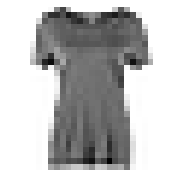

In [11]:
plot_mnistimg(train_dataset, 10)


## Autoencoder class

In [12]:
class autoencoder(nn.Module):
    '''
    Initialization: encoded_space_dim is the dimension of the encoded space 'bottleneck part'
                    Images will be 'compressed' to a vector of dimension encoded_space_dim
    '''
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        self.encoded_space_dim = encoded_space_dim
        
        ###############
        #   ENCODER   #
        ###############
        
        ### Convolutional section
        self.encoder_conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.encoder_flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*32, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        
        ###############
        #   DECODER   #
        ###############
        
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.decoder_unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward_encoder(self, x):
        '''
        Encode part of forward
        x: Image to encode (as Tensor)
        '''
        # Apply convolutions
        x = self.encoder_conv(x)
        # Flatten
        x = self.encoder_flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def forward_decoder(self, x):
        '''
        Decode part of forward
        x: Encoded image [Tensor] of size encoded_space_dim
        '''
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.decoder_unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
    
    def forward(self,x):
        '''
        Encode and Decode
        x: Image to autoencode (as Tensor)
        '''
        x = self.forward_encoder(x)
        x = self.forward_decoder(x)
        
        return(x)
    
    def train_epoch(self, device, progress, loss_fn, optimizer, verbose = False):
        '''
        Train the network for a single step
        '''
        self.train() # Set train mode
        train_loss = 0
        # For each batch
        for i, data in progress:
            X = data[0].to(device) # X input
            
            # Encode and Decode data: this is our reconstructed image
            autoencoded_X = self(X)
            
            # Compute the loss between the real and reconstructed images
            loss = loss_fn(autoencoded_X, X)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.data
            if verbose:
                # Print batch loss
                print('\t partial train loss (single batch): %f' % (loss.data))
                
        return train_loss/(i+1)
        
                
    def plotaimg(self, savefig, epoch=False):
        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        self.to(device)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        self.eval()
        with torch.no_grad():
            rec_img  = self(img)
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(4,2))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Recon')
        axs[0].axis('off')
        axs[1].axis('off')
        # Save figures
        if type(savefig) == str:
            if epoch:
                plt.savefig('./imgs/'+savefig+'rec'+str(epoch)+'.svg', format='svg')
            else:
                plt.savefig('./imgs/'+savefig+'rec.svg', format='svg')
            plt.show()
            plt.close()
        else:
            plt.show()
            plt.close()
        
    def test_epoch(self, device, progress, loss_fn):
        '''
        Test epoch during a step
        '''
        self.eval() # Evaluation mode
        
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_out   = []
            conc_label = []
            
            # For each batch
            for i, data in progress:
                X = data[0].to(device) # X input
                
                # Encode and Decode data: this is our reconstructed image
                autoencoded_X = self(X)
                
                # Append the network output to the lists
                conc_out.append(autoencoded_X)
                # Append the true image to the lists
                conc_label.append(X)
            
            # Create a single tensor with all the values in the lists
            conc_out   = torch.cat(conc_out)
            conc_label = torch.cat(conc_label)
            
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
            
        return val_loss.data
    
    def trainmodel(self, epochs, device, trainloader, testloader, loss_fn, optimizer, prog = False, plotloss = False, savefig=False):
        '''
        Main function to train the model, it iterates epochs-times self.train_epoch
        progress = True: shows the real image and the output of an image at each iteration
        plotloss = True: plots the loss on the test set
        '''
        batches = len(trainloader)
        val_batches = len(testloader)
        
        self.to(device)
        # Saves the error on the test set on an array. if plotloss is True it plots the 
        # learning curve
        val_losses   = []
        train_losses = []
        for epoch in range(epochs):
            print('EPOCH %d/%d' % (epoch + 1, epochs))
            
            train_progress = tqdm(enumerate(trainloader), desc="Training Loss: ", total=batches)
            test_progress = tqdm(enumerate(testloader),   desc="Validat. Loss: ", total=val_batches)
            
            # TRAINING
            train_loss = self.train_epoch(device, train_progress, loss_fn, optimizer)
            train_losses.append(train_loss.cpu())
            
            # TESTING
            val_loss = self.test_epoch(device, test_progress, loss_fn)
            val_losses.append(val_loss.cpu())
            
            print('\t VALIDATION - EPOCH %d/%d - loss: %f\n' % (epoch + 1, epochs, val_loss))
            
            if prog:
                self.plotaimg(savefig=savefig, epoch=epoch)
                
        if plotloss:
            plt.plot(np.arange(len(train_losses)), train_losses, 'o-', label='Train error')
            plt.plot(np.arange(len(val_losses)), val_losses, 'o-', label='Test error')
            plt.legend()
            if type(savefig) == str:
                plt.savefig('./imgs/'+savefig+'losses.svg', format='svg')
                plt.show()
            else:
                plt.show()
            
    def save(self, file=False):
        '''
        Just save the model in ./models folder.
        if file = False it overwrites ./models/autoencoder.pth. else it saves it on the name specified
        '''
        if file:
            torch.save(self.state_dict(), './models/'+str(file))
        else:
            torch.save(self.state_dict(), './models/autoencoder.pth')
            
    def plot_encodedspace(self, savefig):
        '''
        Plot the points of the testset in the encoded space, with a color relative to their label
        ONLY IF encoded_space_dim IS 2 OR 3
        '''
        label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
                     'sneaker','bag','boot']
        if self.encoded_space_dim == 2:
            ### Get the encoded representation of the test samples
            encoded_samples = []
            for sample in tqdm(test_dataset):
                img = sample[0].unsqueeze(0).to(device)
                label = sample[1]
                # Encode image
                self.eval()
                with torch.no_grad():
                    encoded_img  = self.forward_encoder(img)
                # Append to list
                encoded_img = encoded_img.flatten().cpu().numpy()
                encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
                encoded_sample['label'] = label
                encoded_samples.append(encoded_sample)
                
            # Convert to a dataframe
            encoded_samples = pd.DataFrame(encoded_samples)
            
            fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
                             color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
            
            if type(savefig) == str:
                fig.write_image('./imgs/'+savefig+'.svg', engine='kaleido')
            
            fig.show()
            
        if self.encoded_space_dim == 3:
            ### Get the encoded representation of the test samples
            encoded_samples = []
            for sample in tqdm(test_dataset):
                img = sample[0].unsqueeze(0).to(device)
                label = sample[1]
                # Encode image
                self.eval()
                with torch.no_grad():
                    encoded_img  = self.forward_encoder(img)
                # Append to list
                encoded_img = encoded_img.flatten().cpu().numpy()
                encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
                encoded_sample['label'] = label
                encoded_samples.append(encoded_sample)
                
            # Convert to a dataframe
            encoded_samples = pd.DataFrame(encoded_samples)
            fig = px.scatter_3d(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
                                color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
            
            fig.update_traces(marker={'size': 1.5})
            
            if type(savefig) == str:
                fig.write_image('./imgs/'+savefig+'.svg', engine='kaleido')
                
            fig.show()
    
    def dimensionality_reduction(self, algorithm, dataset, savefig=False):
        '''
        Perform dimensionlity reduction of the encoded data.
        algorithm can assume those values:
            pca:  to perform PCA
            tsne: to perform TSNE
            both: to perform both
        '''
        ### Get the encoded representation of the test samples
        dimred_encoded_samples = []
        for sample in tqdm(dataset):
            dimred_img = sample[0].unsqueeze(0).to(device)
            dimred_label = sample[1]
            # Encode image
            self.eval()
            with torch.no_grad():
                dimred_encoded_img  = self.forward_encoder(dimred_img)
            # Append to list
            dimred_encoded_img = dimred_encoded_img.flatten().cpu().numpy()
            dimred_encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(dimred_encoded_img)}
            dimred_encoded_sample['label'] = dimred_label
            dimred_encoded_samples.append(dimred_encoded_sample)

        dimred_encoded_samples = pd.DataFrame(dimred_encoded_samples)
        
        if algorithm == 'pca':
            pca = PCA(n_components=2)
            encoded_samples_reduced_PCA = pca.fit_transform(dimred_encoded_samples)
            
            plt.title('PCA over encoded samples: encoded space dimension = '+str(self.encoded_space_dim))
            plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=dimred_encoded_samples.label.to_numpy())
            plt.show()
            
        elif algorithm == 'tsne':
            tsne = TSNE(n_components=2)
            encoded_samples_reduced_TSNE = tsne.fit_transform(dimred_encoded_samples)
            
            return tsne
            
        elif algorithm == 'both':
            pca = PCA(n_components=2)
            encoded_samples_reduced_PCA = pca.fit_transform(dimred_encoded_samples)
            
            plt.title('PCA over encoded samples: encoded space dimension = '+str(self.encoded_space_dim))
            plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=dimred_encoded_samples.label.to_numpy())
            if type(savefig) == str:
                plt.savefig('./imgs/'+savefig+'_pca.svg', format='svg')
                plt.show()
            else:
                plt.show()
            
            tsne = TSNE(n_components=2)
            encoded_samples_reduced_TSNE = tsne.fit_transform(dimred_encoded_samples)
            
            plt.title('TSNE over encoded samples: encoded space dimension = '+str(self.encoded_space_dim))
            plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=dimred_encoded_samples.label.to_numpy())
            if type(savefig) == str:
                plt.savefig('./imgs/'+savefig+'_tsne.svg', format='svg')
                plt.show()
            else:
                plt.show()
            
        else:
            print('Invalid algorithm parameter')
            
        
    def generate(self, nimg, dataset):
        fig, ax = plt.subplots(1, nimg, figsize=(8,2*nimg))
   
        with torch.no_grad():
            for i in range(nimg):
                img, label = random.choice(dataset)
                img1 = img[0]
                
                encoded_img  = self.forward_encoder(img.unsqueeze(0).to(device))
                gen_img  = self.forward_decoder(20*torch.randn_like(encoded_img).to(device) )
    
                ax[i].imshow(gen_img.squeeze().cpu().numpy(), cmap='gist_gray')
                ax[i].set_title('Generated sample '+str(i+1) )
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                

In [13]:
model = autoencoder(2)
model.to(device)
model


autoencoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d

EPOCH 1/5


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 1/5 - loss: 0.181594



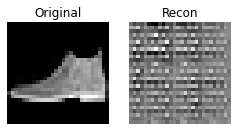

EPOCH 2/5


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 2/5 - loss: 0.091775



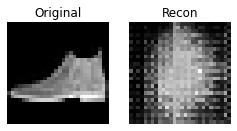

EPOCH 3/5


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 3/5 - loss: 0.079174



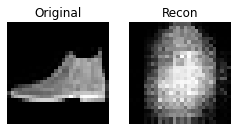

EPOCH 4/5


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 4/5 - loss: 0.074617



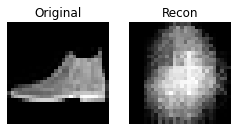

EPOCH 5/5


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 5/5 - loss: 0.059341



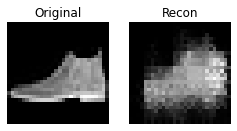

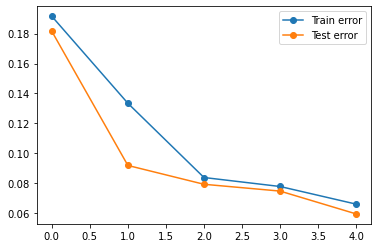

In [14]:
if not load:
    params_to_optimize = [{'params' : model.parameters()}]
    model.trainmodel(5, device, train_dataloader, test_dataloader, torch.nn.MSELoss(), 
                   torch.optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-5),
                   prog = True , plotloss = True, savefig='autoencoder')
    model.save()

else: # load
    model.load_state_dict(torch.load('./models/autoencoder.pth'))
    

In [ ]:
model.plot_encodedspace()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

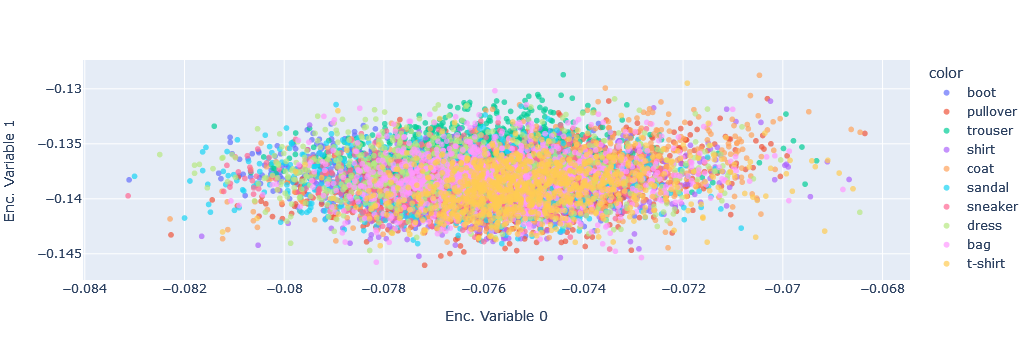

In [272]:
untrained_model = autoencoder(2)
untrained_model.to(device)
untrained_model.plot_encodedspace()


## From Sneaker to Sandal

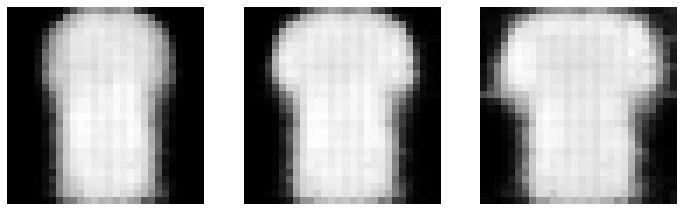

In [275]:
model.to(device)

enc_x = -7
enc_ys = np.linspace(-20,-5,3)

fig, axs = plt.subplots(1, 3, figsize=(12,4))
for i, enc_y in enumerate(enc_ys):
    imag = model.forward_decoder( torch.Tensor([[enc_x,enc_y]]).to(device) ).cpu().detach().numpy()[0][0]
    axs[i].imshow(imag , cmap='gist_gray')
    axs[i].axis('off')

plt.savefig('./imgs/autoencoder_transf.svg', format='svg')

Using Plotly, it is possible to visualize a 3D Encoded Space

In [113]:
model3d = autoencoder(3)
if not load:
    params_to_optimize = [{'params' : model3d.parameters()}]
    model3d.trainmodel(20, device, train_dataloader, test_dataloader, torch.nn.MSELoss(), 
                   torch.optim.Adam(params_to_optimize, lr=1e-2, weight_decay=1e-5), progress = True , plotloss = True)
    model3d.save('autoencoder3d.pth')

else:
    model3d.load_state_dict(torch.load('./models/autoencoder3d.pth'))
    
model3d.plot_encodedspace()

EPOCH 1/20


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Hyperparameters optimization with Optuna

In [94]:
def optuna_find_hparameters(ntrials = 20, nepochs = 10):
    '''
    Function for Optuna hyperparameter tuning
    '''
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='minimize')
    
    optimizers = [torch.optim.Adam, torch.optim.SGD]
    
    def callback(study, trial):
        '''
        Callback function, saves the best model.
        '''
        global best_model
        # If the best model result is the current one...
        if study.best_trial == trial:
            # Saves the best model to best_model
            best_model = optmodel
    
    def optuna_train(trial):
        '''
        Main function for optuna.
        '''
        epochs = nepochs
        cfg = {
          'dimend': trial.suggest_categorical('dimend',[6]),
          'lr' : trial.suggest_loguniform('lr', 1e-4, 1e-3),
          'optimizer': trial.suggest_categorical('optimizer',list(range(len(optimizers))))}
        
        global optmodel
        optmodel =  autoencoder(cfg['dimend'])
        optmodel.to(device)
        
        batches = len(train_dataloader)
        val_batches = len(test_dataloader)
        
        for epoch in range(epochs):
            train_progress = tqdm(enumerate(train_dataloader), desc="Training Loss: ", total=batches, disable=True) # disable progress bar
            test_progress = tqdm(enumerate(test_dataloader),   desc="Validat. Loss: ", total=val_batches, disable=True) # disable progress bar
            # TRAINING
            optmodel.train_epoch(device, train_progress, torch.nn.MSELoss(), optimizers[cfg['optimizer']](optmodel.parameters(), lr=cfg['lr']));
            
            # TESTING
            val_loss = optmodel.test_epoch(device, test_progress, torch.nn.MSELoss())
            
            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        return val_loss
    
    study.optimize(optuna_train, n_trials=ntrials, callbacks=[callback])
    
    optuna_best_params = {
        'dimenc': study.best_params['dimend'],
        'lr'    : study.best_params['lr'],
        'opt'   : optimizers[study.best_params['optimizer']]
    }
    
    return study, optuna_best_params, best_model


In [95]:
study, optuna_best_params, best_model_optuna = optuna_find_hparameters(ntrials = 1, nepochs = 30)
# save the best model
best_model_optuna.save(file='best_autoencoder')

[I 2022-02-02 17:26:05,232] A new study created in memory with name: no-name-9107f92a-e950-4a20-9c6f-cefe44ac626d
[I 2022-02-02 17:29:36,510] Trial 0 finished with value: 0.17143408954143524 and parameters: {'dimend': 6, 'lr': 0.0003958473606175071, 'optimizer': 1}. Best is trial 0 with value: 0.17143408954143524.


In [49]:
print('Best parameters:')
print(optuna_best_params)


Best parameters:
{'dimenc': 6, 'lr': 0.0008874517141815961, 'opt': <class 'torch.optim.adam.Adam'>}


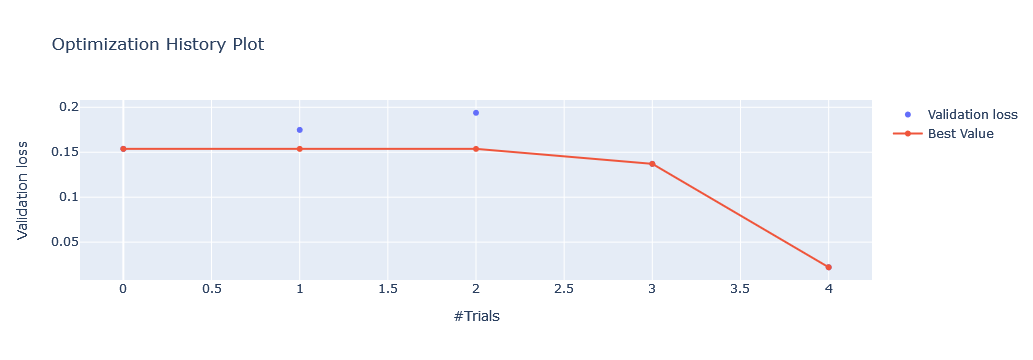

In [50]:
optuna.visualization.plot_optimization_history(study, target_name='Validation loss')


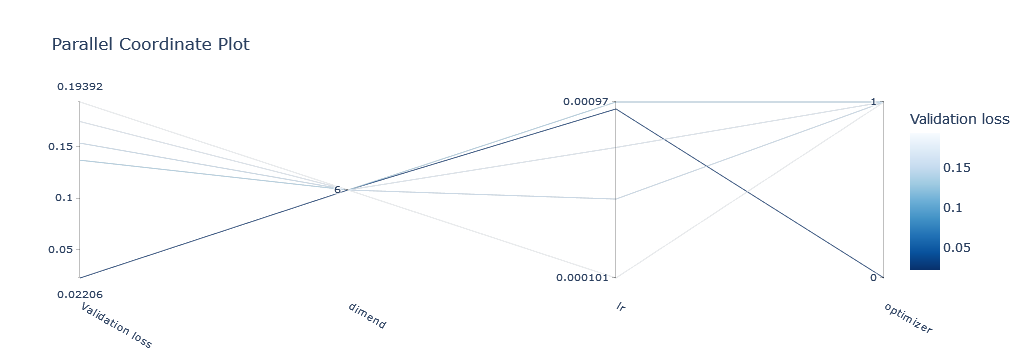

In [51]:
optuna.visualization.plot_parallel_coordinate(study, target_name='Validation loss')


  0%|          | 0/10000 [00:00<?, ?it/s]

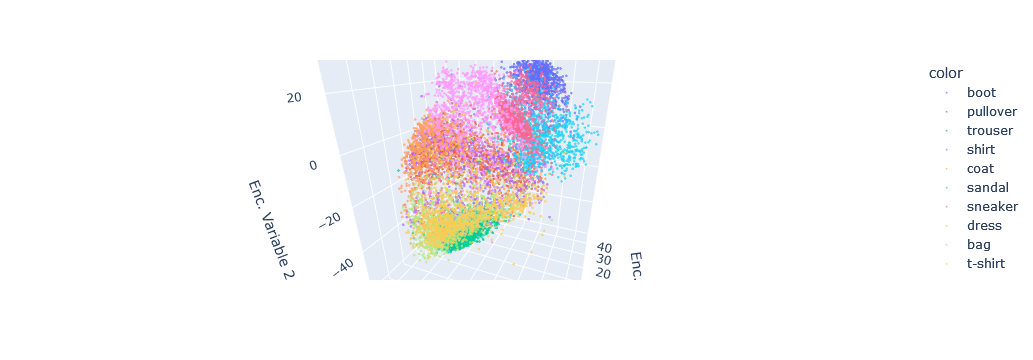

In [24]:
best_model_optuna.plot_encodedspace()

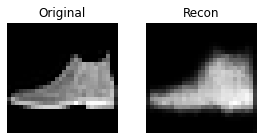

In [52]:
best_model_optuna.plotaimg()

## Latent space structure (PCA, t-SNE)

In [14]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
lats_encoded_space_dim = 10  # this is the only line we change!
lats_autoencoder = autoencoder(lats_encoded_space_dim)
lats_autoencoder.to(device)

### Define the loss function
lats_loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lats_lr = 5e-4 # Learning rate
lats_optim = torch.optim.Adam([{'params': lats_autoencoder.parameters()}], lr=lats_lr, weight_decay=1e-5)

lats_autoencoder.trainmodel(10, device, train_dataloader, test_dataloader, lats_loss_fn, 
                           lats_optim)
lats_autoencoder.save('lats_autoencoder.pth')


EPOCH 1/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 1/10 - loss: 0.138367

EPOCH 2/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 2/10 - loss: 0.097000

EPOCH 3/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 3/10 - loss: 0.087520

EPOCH 4/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 4/10 - loss: 0.062342

EPOCH 5/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 5/10 - loss: 0.046761

EPOCH 6/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 6/10 - loss: 0.040988

EPOCH 7/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 7/10 - loss: 0.034309

EPOCH 8/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 8/10 - loss: 0.030765

EPOCH 9/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 9/10 - loss: 0.028887

EPOCH 10/10


Training Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Validat. Loss:   0%|          | 0/1 [00:00<?, ?it/s]

	 VALIDATION - EPOCH 10/10 - loss: 0.027313



  0%|          | 0/10000 [00:00<?, ?it/s]

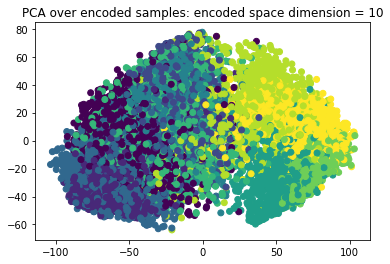

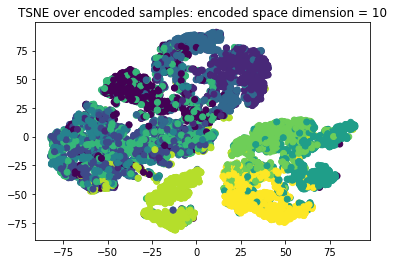

In [15]:
# autoencoder.dimensionality_reduction either PCA or TSNE (or both)
# if arg1 == pca performs PCA
# if arg1 == tsne performs TSNE
# if arg1 == both performs both PCA and TSNE
lats_autoencoder.dimensionality_reduction('both', test_dataset, savefig='lats')

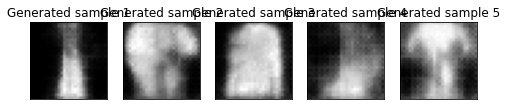

In [28]:
lats_autoencoder.generate(5, test_dataset)

## Supervised Classification Task using Autoencoder

In [78]:
class sup_autoencoder(nn.Module):
    def __init__(self, autoencoder):
        '''
        Initialization: Takes encoder part of an already trained model "autoencoder".
                        Adds fine tuner part: 2 fully connected layers and a LogSoftMax activation
        '''
        super().__init__()
        
        self.encoded_space_dim = autoencoder.encoded_space_dim
        
        ###############
        #   ENCODER   #
        ###############
        
         ### Convolutional section
        self.encoder_conv = autoencoder.encoder_conv
        
        ### Flatten layer
        self.encoder_flatten = autoencoder.encoder_flatten

        ### Linear section
        self.encoder_lin = autoencoder.encoder_lin
        
        # Decoder part is with two fully connected layers
        # the logsoftmax activation at the end to generate probability for each classe
        self.fine_tuner =  nn.Sequential( nn.Linear(self.encoded_space_dim, 256),
                                          nn.ReLU(True),
                                          nn.Dropout(.1),
                                          nn.Linear(256,256),
                                          nn.ReLU(True),
                                          nn.Dropout(.1),
                                          nn.Linear(256,128),
                                          nn.ReLU(True),
                                          nn.Linear(128, 10),
                                          nn.LogSoftmax(-1) )
        
    def forward(self, x):
        '''
        Encode and pass through fine tuner
        '''
        # FORWARD ENCODER
        x = self.encoder_conv(x)
        x = self.encoder_flatten(x)
        x = self.encoder_lin(x)
        # FINE TUNER
        x = self.fine_tuner(x)
                
        return x
    
    def train_epoch(self, device, progress, loss_fn, optimizer, total_loss, verbose = False):
        '''
        Train the network for a single step
        '''
        self.train() # Set train mode
        
        # Iterate the dataloader
        for i, data in progress:
            image_batch, label_batch = data[0].to(device), data[1].to(device)
            
            # Encode and Decode data: this is our reconstructed image
            pred_batch = self(image_batch)
            
            # Compute the loss between the real and reconstructed images
            loss = loss_fn(pred_batch, label_batch)
            
            # getting training quality data
            current_loss = loss.item() # Extract loss value as float
            total_loss += current_loss
            
            # updating progress bar
            progress.set_description("Train. Loss: {:.4f}".format(total_loss/(i+1)))
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        return total_loss, optimizer
                
    def test_epoch(self, device, progress, loss_fn, total_loss):
        '''
        Test epoch during a step
        '''
        self.eval() # Evaluation mode
        
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_out   = []
            conc_label = []
            
            # Iterate the dataloader
            for i, data in progress:
                image_batch, label_batch = data[0].to(device), data[1].to(device)
                
                # Encode and Decode data: this is our reconstructed image
                pred_batch = self(image_batch)
                
                # Append the network output to the lists
                conc_out.append(pred_batch)
                # Append the true image to the lists
                conc_label.append(label_batch.to(device))
            
            # Create a single tensor with all the values in the lists
            conc_out   = torch.cat(conc_out)
            conc_label = torch.cat(conc_label)
            
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
            
            # getting training quality data
            current_loss = val_loss.item() # Extract loss value as float
            total_loss += current_loss
            
            # updating progress bar
            progress.set_description("Vali. Loss: {:.4f}".format(total_loss/(i+1)))
            
        return val_loss.data
    
    def trainmodel(self, epochs, device, trainloader, testloader, loss_fn, optimizer, plotloss = False):
        '''
        Main function to train the model, it iterates epochs-times self.train_epoch
        progress = True: shows the real image and the output of an image at each iteration
        plotloss = True: plots the loss on the test set
        '''
        batches = len(trainloader)
        val_batches = len(testloader)
        self.to(device)
        # Saves the error on the test set on an array. if plotloss is True it plots the 
        # learning curve
        val_losses   = []
        
        for epoch in range(epochs):
            train_loss_per_epoch, val_loss_per_epoch = 0, 0
            
            print('EPOCH %d/%d' % (epoch + 1, epochs))
            train_progress = tqdm(enumerate(trainloader), desc="Training Loss: ", total=batches, disable=True)
            test_progress = tqdm(enumerate(testloader),   desc="Validat. Loss: ", total=val_batches, disable=True)
            
            # TRAINING
            _, optimizer = self.train_epoch(device, train_progress, loss_fn, optimizer, train_loss_per_epoch)
            
            # TESTING
            val_loss = self.test_epoch(device, test_progress, loss_fn, val_loss_per_epoch)
            val_losses.append(val_loss.cpu())
            
            print('\t VALIDATION - EPOCH %d/%d - loss: %f\n' % (epoch + 1, epochs, val_loss))
                
        if plotloss:
            plt.plot(np.arange(len(val_losses)), val_losses, 'o-', label='Test error')
            plt.legend()
            plt.show()
            plt.close()
            
    def compute_accuracy(self, dataloader, heatmap = False, verbose = False):
        '''
        Compute accuracy of the model (%) from the testset
        heatmap  = True shows heatmap
        verbose  = True prints accuracy
        examples = True display some examples
        '''
        self.eval() # Evaluation mode
        self.to(device)
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            conc_pred   = []
            conc_label = []
            
            for image_batch, label_batch in dataloader:
                # Move tensor to device
                image_batch = image_batch.to(device)
                
                # Encode and Decode data: this is our reconstructed image
                pred_batch = self(image_batch).argmax(dim=1)
                
                # Append the network output to the lists
                conc_pred.append(pred_batch.to(device))
                # Append the true image to the lists
                conc_label.append(label_batch)
            
            # Create a single tensor with all the values in the lists
            conc_pred   = torch.cat(conc_pred)
            conc_label  = torch.cat(conc_label)
        
        description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
        
        misclas = 0
        for i in range(len(conc_pred) ):
            if conc_pred[i] != conc_label[i]:
                misclas = misclas + 1
        
        accuracy = 100*(len(conc_pred) - misclas)/len(conc_pred)
        
        if verbose:
            print('Accuracy:', accuracy, '%' )
            
        if heatmap:
            conf_mat = confusion_matrix(conc_label.cpu(), conc_pred.cpu())
            fig, ax = plt.subplots(figsize=(10,8))
            plt.title('Heatmap')
            sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=description, yticklabels=description)
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            
        return accuracy
            
    def save(self, file=False):
        '''
        Just save the model in ./models folder.
        if file = False it overwrites ./models/finetuner.pth. else it saves it on the name specified
        '''
        if file:
            torch.save(self.state_dict(), './models/'+str(file))
        else:
            torch.save(self.state_dict(), './models/finetuner.pth')
            

In [82]:
ftuner = sup_autoencoder(best_model_optuna)
ftuner


sup_autoencoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=6, bias=True)
  )
  (fine_tuner): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=128, out_features=10, 

In [83]:
for param in ftuner.encoder_conv.parameters():
    param.requires_grad = False
for param in ftuner.encoder_flatten.parameters():
    param.requires_grad = False
for param in ftuner.encoder_lin.parameters():
    param.requires_grad = False
    

In [84]:
# For the optimizer in training, the weights of the encoder are frozen, because we are only optimizing
# the weights (and biases) of the fine_tuner parameters:
ftuner.trainmodel(25, device, train_dataloader, test_dataloader, nn.CrossEntropyLoss(), 
                  torch.optim.Adam([{'params' : ftuner.fine_tuner.parameters()}], lr=1e-3, weight_decay=1e-5) )



EPOCH 1/50
	 VALIDATION - EPOCH 1/50 - loss: 0.689010

EPOCH 2/50
	 VALIDATION - EPOCH 2/50 - loss: 0.644564

EPOCH 3/50
	 VALIDATION - EPOCH 3/50 - loss: 0.626658

EPOCH 4/50
	 VALIDATION - EPOCH 4/50 - loss: 0.620806

EPOCH 5/50
	 VALIDATION - EPOCH 5/50 - loss: 0.614660

EPOCH 6/50
	 VALIDATION - EPOCH 6/50 - loss: 0.609457

EPOCH 7/50
	 VALIDATION - EPOCH 7/50 - loss: 0.602524

EPOCH 8/50
	 VALIDATION - EPOCH 8/50 - loss: 0.606041

EPOCH 9/50
	 VALIDATION - EPOCH 9/50 - loss: 0.596705

EPOCH 10/50
	 VALIDATION - EPOCH 10/50 - loss: 0.594208

EPOCH 11/50
	 VALIDATION - EPOCH 11/50 - loss: 0.594548

EPOCH 12/50
	 VALIDATION - EPOCH 12/50 - loss: 0.592764

EPOCH 13/50
	 VALIDATION - EPOCH 13/50 - loss: 0.588092

EPOCH 14/50
	 VALIDATION - EPOCH 14/50 - loss: 0.584868

EPOCH 15/50
	 VALIDATION - EPOCH 15/50 - loss: 0.584147

EPOCH 16/50
	 VALIDATION - EPOCH 16/50 - loss: 0.590522

EPOCH 17/50
	 VALIDATION - EPOCH 17/50 - loss: 0.585699

EPOCH 18/50
	 VALIDATION - EPOCH 18/50 - loss: 0.

Accuracy: 77.98 %


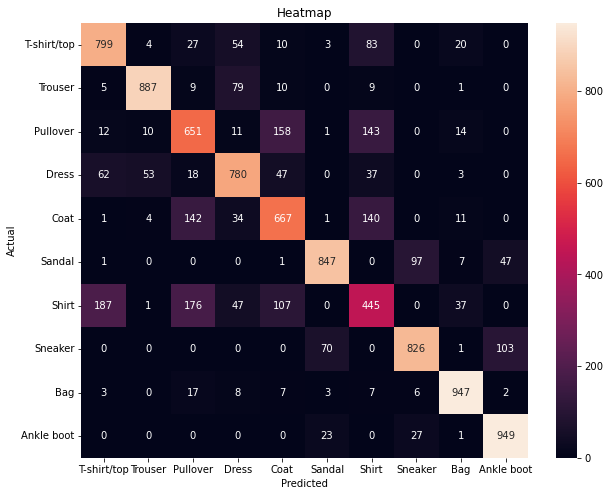

77.98

In [85]:
ftuner.compute_accuracy(test_dataloader, heatmap=True, verbose=True)

## Implementation of a Generative Adversarial Network

In [238]:
class gan(nn.Module):
    '''
    Initialization: Initialize a GAN model
    latent_dim: dimension of the latent vector (Images get generated by the latent vector)
    hidden_size: number of neurons in the hidden layers
    '''
    def __init__(self, latent_dim, hidden_size):
        super(gan, self).__init__()
        
        self.latent_size  = latent_dim
        self.hidden_size = hidden_size
        image_size = 784 # 28x28, FashionMNIST image size
        
        self.discriminator =  nn.Sequential(
                                nn.Linear(image_size, self.hidden_size),
                                nn.LeakyReLU(0.2),
                                nn.Linear(self.hidden_size, self.hidden_size),
                                nn.LeakyReLU(0.2),
                                nn.Linear(self.hidden_size, 1),
                                nn.Sigmoid() )
        
        self.generator = nn.Sequential(
                            nn.Linear(self.latent_size, self.hidden_size),
                            nn.ReLU(),
                            nn.Linear(self.hidden_size, self.hidden_size),
                            nn.ReLU(),
                            nn.Linear(self.hidden_size, image_size),
                            nn.Tanh() )
        
    def forward_discriminator(self, x):
        return self.discriminator(x)
    
    def forward_generator(self, x):
        return self.generator(x)
        
    def train_discriminator(self, criterion, images, batch_size, device, g_optimizer, d_optimizer):
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Loss for real images
        outputs = self.discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Loss for fake images
        z = torch.randn(batch_size, self.latent_size).to(device)
        fake_images = self.forward_generator(z)
        outputs = self.forward_discriminator(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
    
        # So essentially, you use the given set of real images and feed it to the discriminator and train to understand the pattern of the real images.
        # Then, you generate a bunch of fake images and then feed them to the discriminator to train them to understand the pattern of the fake images.

        # Combine losses
        d_loss = d_loss_real + d_loss_fake
        # Reset gradients
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        # Compute gradients
        d_loss.backward()
        # Adjust the parameters using backprop
        d_optimizer.step()
    
        return d_loss, real_score, fake_score, g_optimizer, d_optimizer
    
    def train_generator(self, criterion, batch_size, device, g_optimizer, d_optimizer):
        # Generate fake images and calculate loss
        z = torch.randn(batch_size, self.latent_size).to(device)
        fake_images = self.forward_generator(z)
        labels = torch.ones(batch_size, 1).to(device)
        g_loss = criterion(self.forward_discriminator(fake_images), labels)

        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        g_loss.backward()
        g_optimizer.step()
        return g_loss, fake_images, g_optimizer, d_optimizer
        
    def trainmodel(self, epochs, lr, dataloader, device, regterm = 1e-3, plotloss = False, savefig = False):
        '''
        Main model for training the GAN
        '''
        total_step = len(dataloader) # number of batches
        d_losses, g_losses, real_scores, fake_scores = [], [], [], []
        batch_size = 1200
        criterion = nn.BCELoss()
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr, weight_decay=regterm)
        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr, weight_decay=regterm)
        self.to(device)
        for epoch in range(epochs):
            for i, (images, _) in enumerate(dataloader):
                # Load a batch & transform to vectors
                images = images.reshape(batch_size, -1).to(device)
        
                # Train the discriminator and generator
                self.train()
                d_loss, real_score, fake_score, g_optimizer, d_optimizer = self.train_discriminator(criterion, images, batch_size, device, g_optimizer, d_optimizer)
                g_loss, fake_images, g_optimizer, d_optimizer = self.train_generator(criterion, batch_size, device, g_optimizer, d_optimizer)
                # Inspect the losses
                if (i+1) % total_step == 0:
                    d_losses.append(d_loss.item())
                    g_losses.append(g_loss.item())
                    real_scores.append(real_score.mean().item())
                    fake_scores.append(fake_score.mean().item())
                    if epoch % 50 == 0:
                        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                              .format(epoch, epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                                      real_score.mean().item(), fake_score.mean().item()))
            
                        z = Variable(torch.randn(9, self.latent_size)).cuda()
                        #sample_images = generator(z).data
                        sample_images = self.forward_generator(z)
                        sample_images = sample_images.view(sample_images.size(0), 28, 28).unsqueeze(1).data.cpu()
                        grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
                        plt.imshow(grid)
                        plt.axis('off')
                        
                        if type(savefig) == str:
                            plt.savefig('./imgs/'+savefig+str(epoch)+'.svg', format='svg')
                            plt.show()
                        else:
                            plt.show()
        
        if plotloss: # Plot loss of generator and discriminator
            plt.plot(d_losses, '-')
            plt.plot(g_losses, '-')
            plt.xlabel('epoch')
            plt.legend(['Discriminator', 'Generator'])
            plt.title('Losses');
            
            if type(savefig) == str:
                plt.savefig('./imgs/'+savefig+'losses.svg', format='svg')
                plt.show()
            else:
                plt.show()
        
    def save(self, file=False):
        '''
        Just save the model in ./models folder.
        if file = False it overwrites ./models/gan.pth. else it saves it on the name specified
        '''
        if file:
            torch.save(self.state_dict(), './models/'+str(file))
        else:
            torch.save(self.state_dict(), './models/gan.pth')
            

Epoch [0/3], Step [50/50], d_loss: 1.5952, g_loss: 1.0600, D(x): 0.40, D(G(z)): 0.48


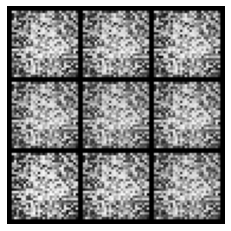

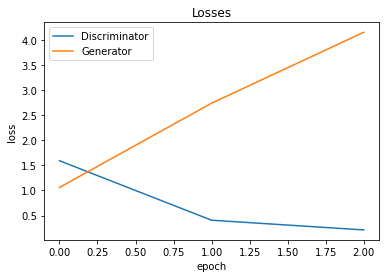

In [239]:
latent_size = 100
hidden_size = 784
fashiongan = gan(latent_size, hidden_size)

fashiongan.trainmodel(3, 0.0001, train_dataloader, device, savefig='gan', plotloss=True)